In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import healpy as hp

import yaml

from Qatmosphere_2d import Atmsophere

import scipy
import scipy.special as sci_spe
import time
from astropy.time import TimeDelta
 
import sys
import yaml

sys.path.append('/home/laclavere/qubic/qubic/Pipeline')

import qubic
from qubic.lib.Qscene import QubicScene

from pyoperators.iterative.core import AbnormalStopIteration
from pysimulators import (
    CartesianEquatorial2GalacticOperator,
    CartesianEquatorial2HorizontalOperator,
    CartesianHorizontal2EquatorialOperator,
    CartesianGalactic2EquatorialOperator,
    SamplingHorizontal,
    SphericalEquatorial2GalacticOperator,
    SphericalGalactic2EquatorialOperator,
    SphericalEquatorial2HorizontalOperator,
    SphericalHorizontal2EquatorialOperator)
from pysimulators.interfaces.healpy import Cartesian2HealpixOperator, Spherical2HealpixOperator
from pyoperators import *

%matplotlib inline

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
with open('/home/laclavere/Documents/Thesis/qubic/qubic/scripts/Atmosphere/params.yml', 'r') as file:
    params = yaml.safe_load(file)

In [3]:
atm = Atmsophere(params)

In [4]:
rho = atm.mean_water_vapor_density
print(rho)

[16.87483793]


In [5]:
delta_rho = atm.generate_spatial_fluctuations_2d()
print(type(delta_rho))

<class 'numpy.ndarray'>


In [6]:
atm.get_water_vapor_density_2d_map()

array([[57.06477804, 57.06489036, 57.06601506, ..., 57.06422432,
        57.06401969, 57.06459805],
       [57.06604608, 57.06699157, 57.0671188 , ..., 57.0651199 ,
        57.06537167, 57.06557059],
       [57.06824915, 57.06762683, 57.06678569, ..., 57.06629885,
        57.0652674 , 57.06623494],
       ...,
       [57.06368507, 57.06384925, 57.06316491, ..., 57.06278996,
        57.06335683, 57.06223141],
       [57.06417918, 57.0651232 , 57.06473943, ..., 57.0637863 ,
        57.06294272, 57.06285504],
       [57.06375751, 57.06483921, 57.06648549, ..., 57.0646697 ,
        57.06401962, 57.06392622]])

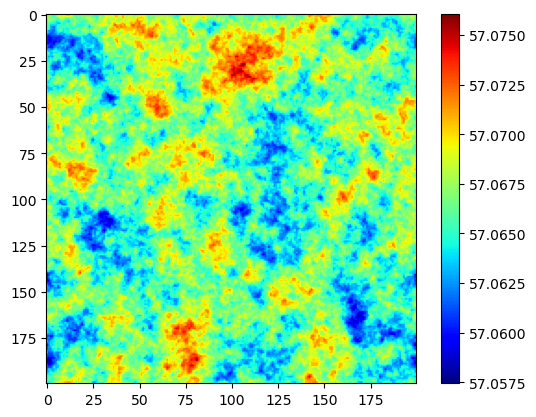

In [7]:
plt.imshow(atm.get_water_vapor_density_2d_map(), cmap='jet')
plt.colorbar()

In [8]:
map_temp = atm.get_maps()
frequencies = atm.integrated_absorption_spectrum()[1]

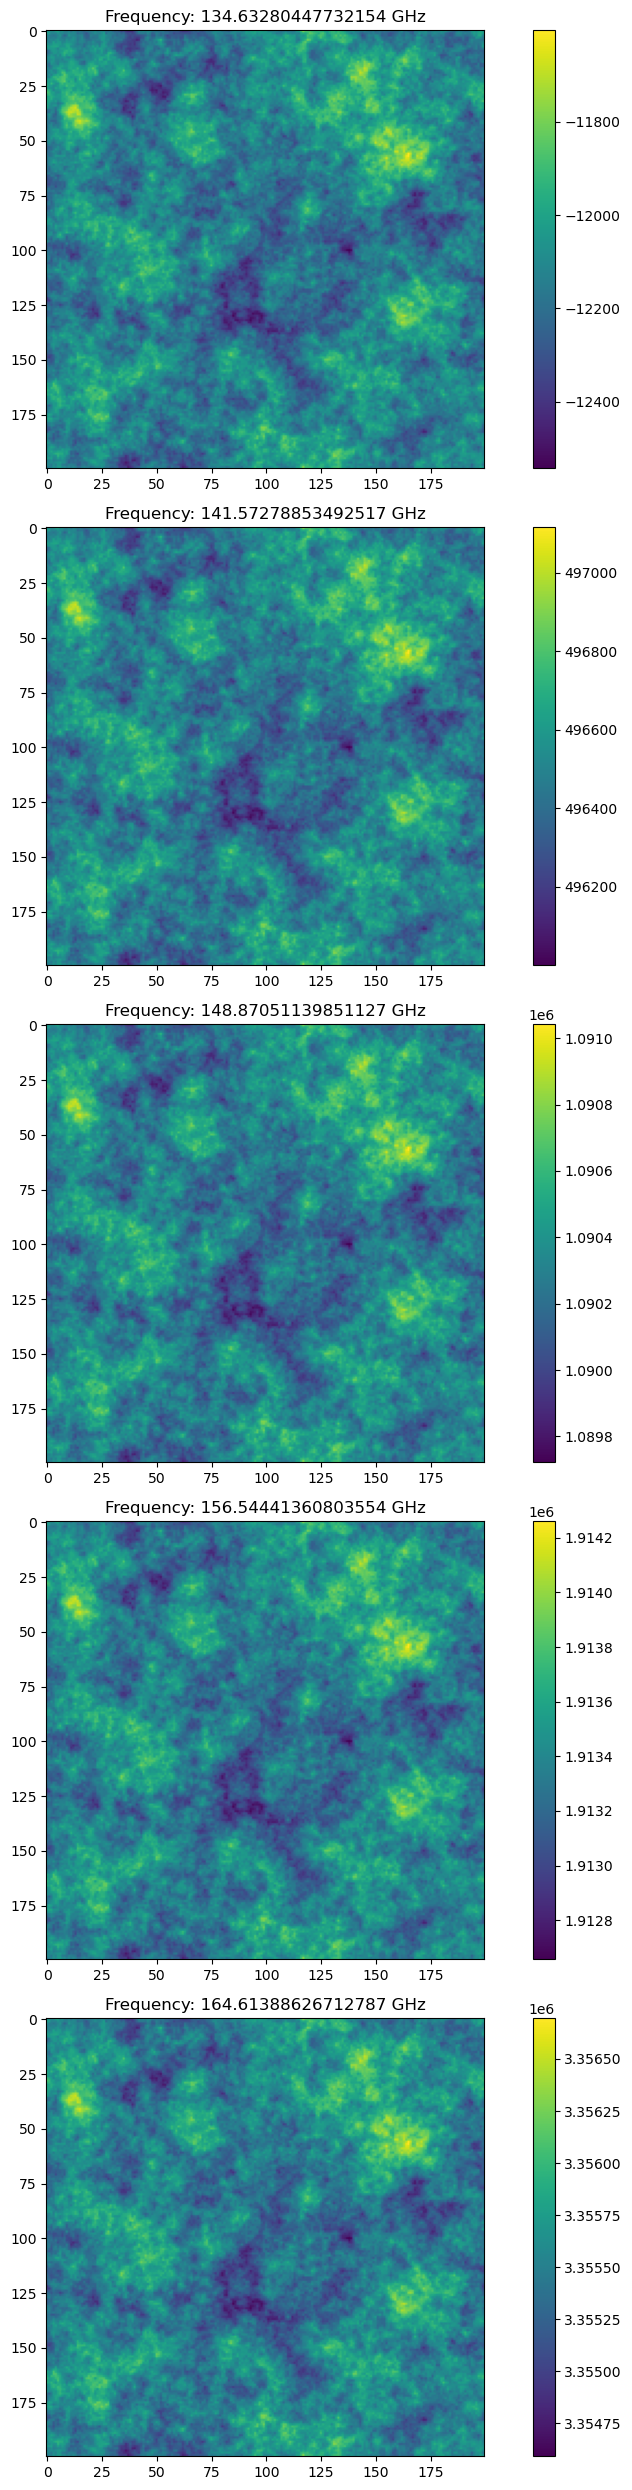

In [9]:
fig, axs = plt.subplots(len(frequencies), 1, figsize=(10, 5*len(frequencies)))
for i in range(len(frequencies)):
    im = axs[i].imshow(map_temp[i])
    plt.colorbar(im, ax=axs[i])
    axs[i].set_title(f'Frequency: {frequencies[i]} GHz')
plt.tight_layout()
plt.show()

In [10]:
r, az, el = atm.r, atm.az, atm.el
x_list, y_list, z_list = atm.x_list, atm.y_list, atm.altitude

In [11]:
az.shape

(200, 200)

In [12]:
az_list, el_list = [], []
atm_value = []
for ind_x in range(len(x_list)):
    for ind_y in range(len(y_list)):
        azel = atm.horizontal_plane_to_azel(x_list[ind_x], y_list[ind_y], z_list[0])
        az_list.append(azel[1])
        el_list.append(azel[2])

In [13]:
center = np.array([0, -57])


In [14]:
rota = Cartesian2SphericalOperator('azimuth,elevation')(Rotation3dOperator("ZY'", atm.qubic_dict['latitude'], atm.qubic_dict['longitude'], degrees=True)(Spherical2CartesianOperator('azimuth,elevation')))
rotation_azel2hp = Spherical2HealpixOperator(params['nside'], 'azimuth,elevation')

In [15]:
azel = np.asarray([az_list, el_list]).T
hp_map_0 = rotation_azel2hp(azel).astype(int)

In [16]:
hp_map_qubic = rotation_azel2hp(rota(azel)).astype(int)

In [17]:
atm.get_maps()[0].flatten().shape

(40000,)

In [18]:
test=np.zeros(hp.nside2npix(params['nside']))

test = atm.get_healpy_atm_maps_2d()

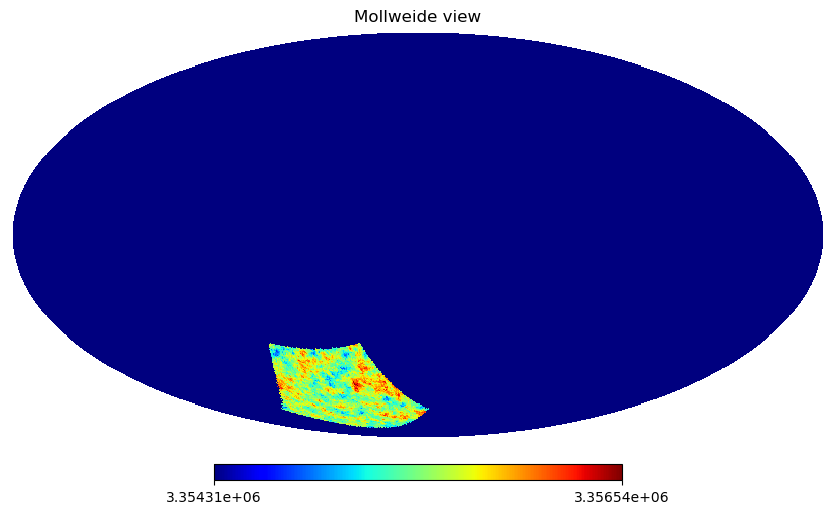

In [19]:
hp.mollview(test[-1], min=np.min(atm.get_maps()[-1]), cmap='jet')

In [20]:
atm.qubic_dict['latitude']

-24.183333333333334

In [21]:
stop

NameError: name 'stop' is not defined

In [13]:
from lib.InstrumentModel.Qacquisition import QubicMultiAcquisitions

ModuleNotFoundError: No module named 'lib'

In [10]:
def get_dict(params, comm, key='in'):
    """QUBIC dictionary.

    Method to modify the qubic dictionary.

    Parameters
    ----------
    key : str, optional
        Can be "in" or "out".
        It is used to build respectively the instances to generate the TODs or to reconstruct the sky maps,
        by default "in".

    Returns
    -------
    dict_qubic: dict
        Modified QUBIC dictionary.

    """

    args = {
        "npointings": params["QUBIC"]["npointings"],
        "nf_recon": params["QUBIC"]["nrec"],
        "nf_sub": params["QUBIC"][f"nsub_{key}"],
        "nside": params["SKY"]["nside"],
        "MultiBand": True,
        "period": 1,
        "RA_center": params["SKY"]["RA_center"],
        "DEC_center": params["SKY"]["DEC_center"],
        "filter_nu": 150 * 1e9,
        "noiseless": False,
        "comm": comm,
        "dtheta": params["QUBIC"]["dtheta"],
        "nprocs_sampling": 1,
        "nprocs_instrument": comm.Get_size(),
        "photon_noise": True,
        "nhwp_angles": 3,
        #'effective_duration':3,
        "effective_duration150": 3,
        "effective_duration220": 3,
        "filter_relative_bandwidth": 0.25,
        "type_instrument": "two",
        "TemperatureAtmosphere150": None,
        "TemperatureAtmosphere220": None,
        "EmissivityAtmosphere150": None,
        "EmissivityAtmosphere220": None,
        "detector_nep": float(params["QUBIC"]["NOISE"]["detector_nep"]),
        "synthbeam_kmax": params["QUBIC"]["SYNTHBEAM"]["synthbeam_kmax"],
    }

    ### Get the default dictionary
    dictfilename = "dicts/pipeline_demo.dict"
    dict_qubic = qubic.lib.Qdictionary.qubicDict()
    dict_qubic.read_from_file(dictfilename)

    for i in args.keys():

        dict_qubic[str(i)] = args[i]

    return dict_qubic